# Simple notebook to do a comparitive time series between one or more countries as well as giving a daily change in no of Corona Cases for India

In [149]:
import requests
import io 
import pandas as pd

In [150]:
# Load Corona Virus Data
url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))



In [151]:
# Function for getting data for country 
def getDataForCountry(countryName,dataFr):
    df_country = dataFr.loc[df['Country/Region'] == countryName]
    df_country = df_country.transpose()
    df_country=df_country.drop(df_country.index[[0,1,2,3]])
    df_country[countryName] =  df_country.iloc[: , 0]

    # Iterate over the sequence of column names to append
    for index in range(df_country.shape[1]-1):
       if index>0:
           df_country[countryName] =  df_country[countryName] +  df_country.iloc[: , index]
    # Remove the extra columns 
    for index in range(df_country.shape[1]-1):
        df_country.drop(df_country.columns[0], axis = 1, inplace = True) 
    return df_country;





In [152]:
# Function for getting data for country 
def getDataChangeForCountry(countryName,dataFr,days):
    df_country=getDataForCountry(countryName,dataFr).tail(days)
    df_country['New Cases-'+countryName] = df_country[countryName] - df_country[countryName].shift(1) 
    df_country['Daily Change-'+countryName] = (df_country['New Cases-'+countryName]/df_country[countryName])*100 
    return df_country;





In [153]:
# Function for getting data for Province
def getDataForProvince(provinceName,dataFr):
    df_pr = dataFr.loc[df['Province/State'] == provinceName]
    df_pr = df_pr.transpose()
    df_pr=df_pr.drop(df_pr.index[[0,1,2,3]])
    df_pr.columns=[provinceName]
    #df_pr['delta'] = df_pr[countryName] - df_pr[countryName].shift(1) 

    return df_pr;

In [154]:
def drawChartForVirus(countriesList,provinceList,log=False,delta=False):
    ax = getDataForCountry(countriesList[0],df).plot(figsize=(25,10),title="No of Confirmed Cases ",fontsize=20,logy=log,lw=4)
    # Using for loop and ignoring the first country
    count=0
    for countryName in countriesList:
        if count >0:
            getDataForCountry(countryName,df).plot(ax=ax,lw=4)
        count=count+1
    
    for provinceName in provinceList: 
        getDataForProvince(provinceName,df).plot(ax=ax,lw=4)

    ax.legend(loc=2, prop={'size': 25})
    if log:
        ax.set_title("Log -  No of Confirmed Cases", size=30)
    else:
        ax.set_title(" No of Confirmed Cases", size=30)

    return;

In [155]:
def drawDeltaChartForVirus(countriesList,percentage=False,days=30):
    if percentage:
        ax = getDataChangeForCountry(countriesList[0],df,days).plot.bar(y='Daily Change-'+countriesList[0],figsize=(25,10),title="No of Confirmed Cases ",fontsize=20,lw=4)
    else:
        ax = getDataChangeForCountry(countriesList[0],df,days).plot.bar(y='New Cases-'+countriesList[0],figsize=(25,10),title="No of Confirmed Cases ",fontsize=20,lw=4)
        # Moving Average ? 
        
    count=0
    for countryName in countriesList:
        if count >0:
            if percentage:
                  getDataChangeForCountry(countryName,df,days).plot.bar(ax=ax,y='Daily Change-'+countryName)
            else:    
                  getDataChangeForCountry(countryName,df,days).plot.bar(ax=ax,y='New Cases-'+countryName)     
    ax.legend(loc=2, prop={'size': 25})
    if percentage:
        ax.set_title("Percentage Increase -  Daily New Cases - "+countryName, size=30)
    else:
        ax.set_title("Daily New Cases - "+countryName, size=30)

    return;

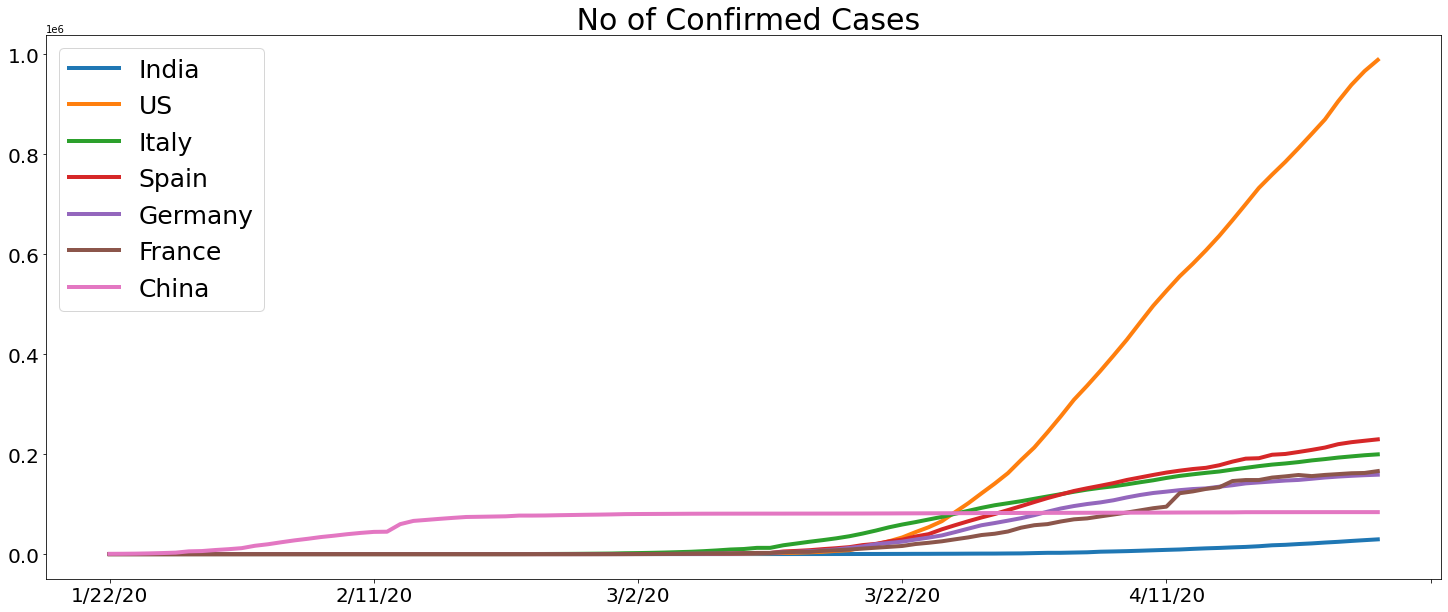

In [156]:
drawChartForVirus(["India","US","Italy","Spain","Germany","France","China"],[],False )

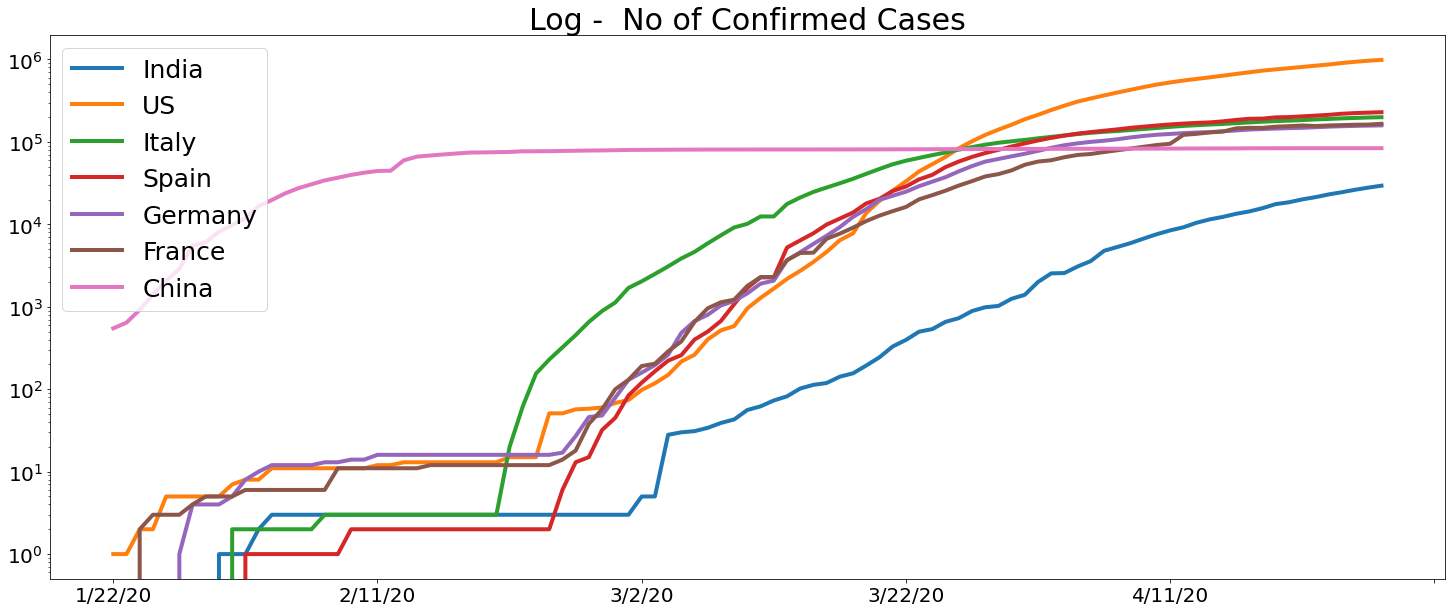

In [157]:
drawChartForVirus(["India","US","Italy","Spain","Germany","France","China"],[],True )

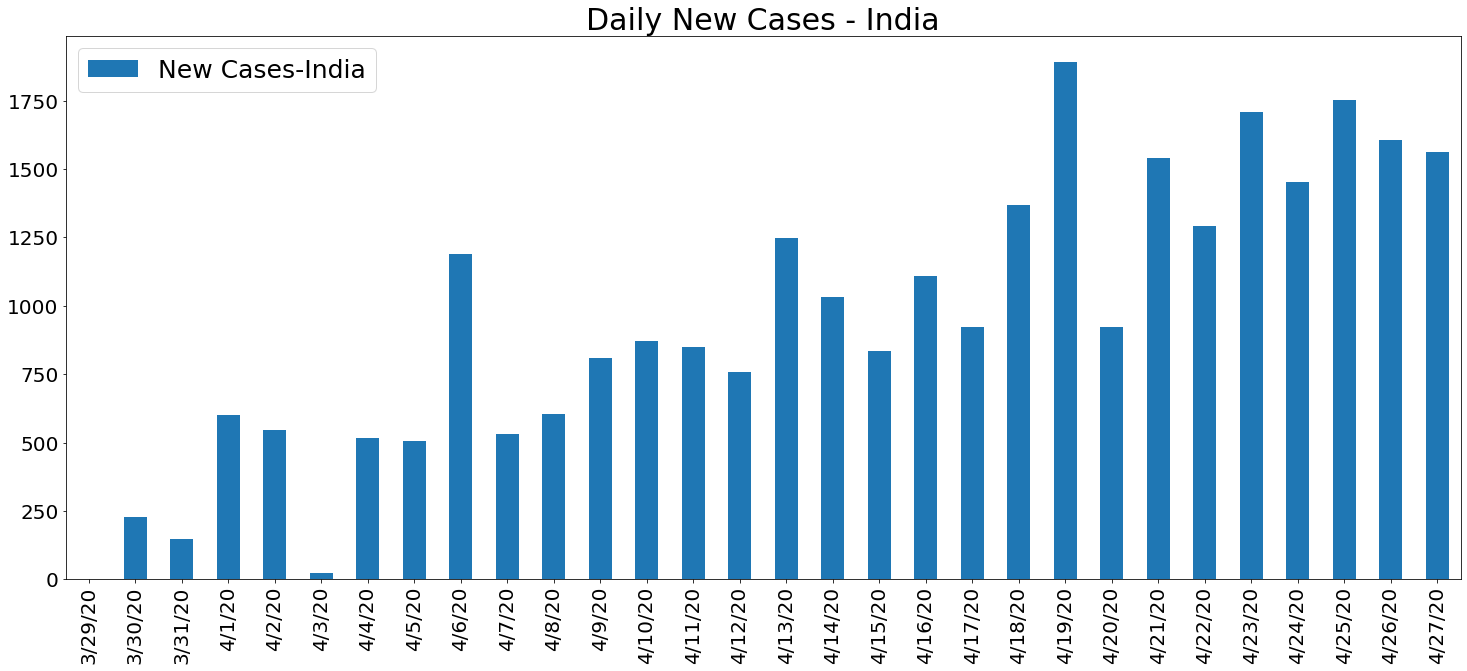

In [158]:
drawDeltaChartForVirus(["India"],False )

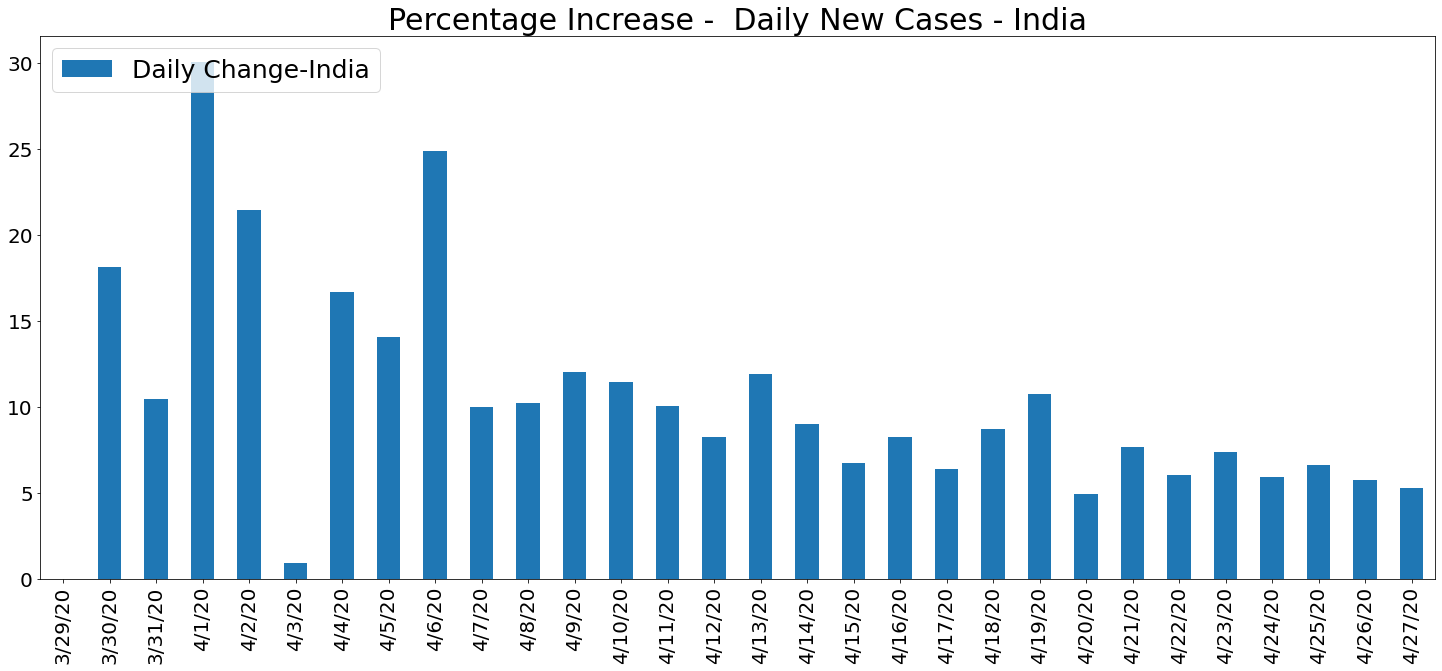

In [159]:
drawDeltaChartForVirus(["India"],True,30)

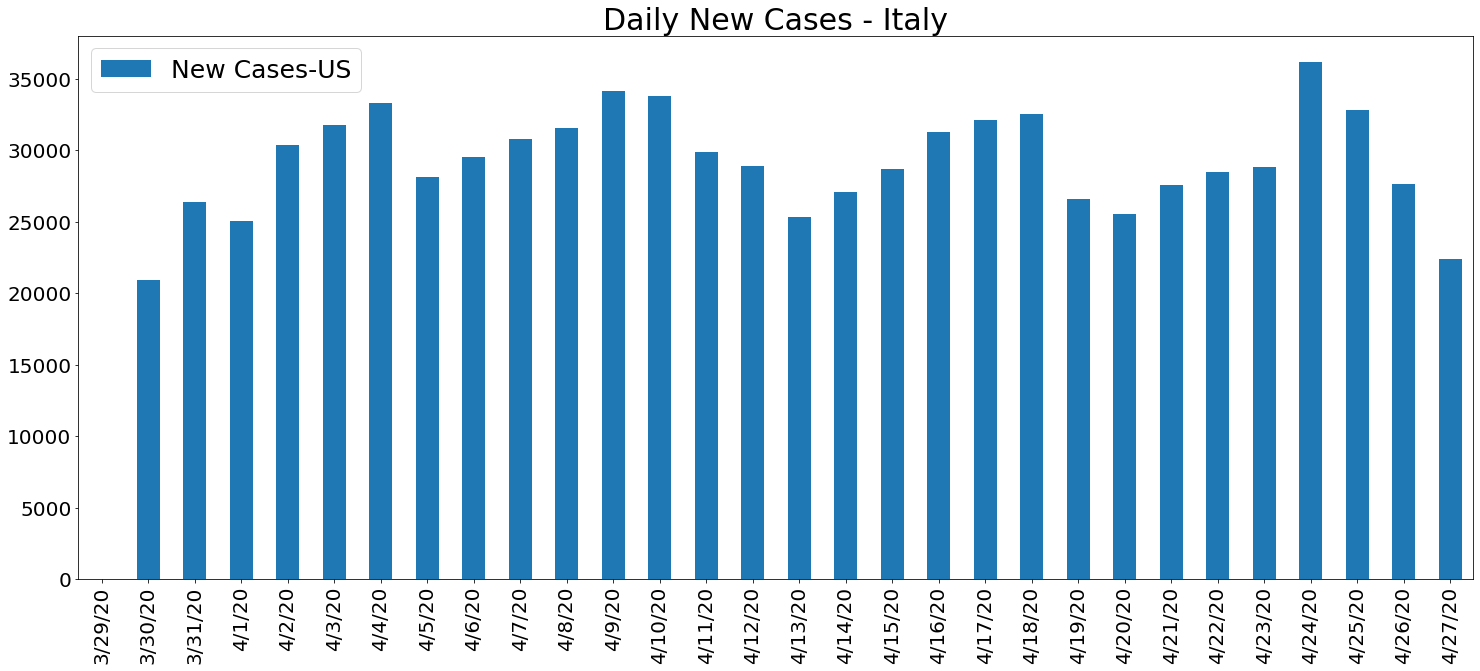

In [145]:
drawDeltaChartForVirus(["US"],False )

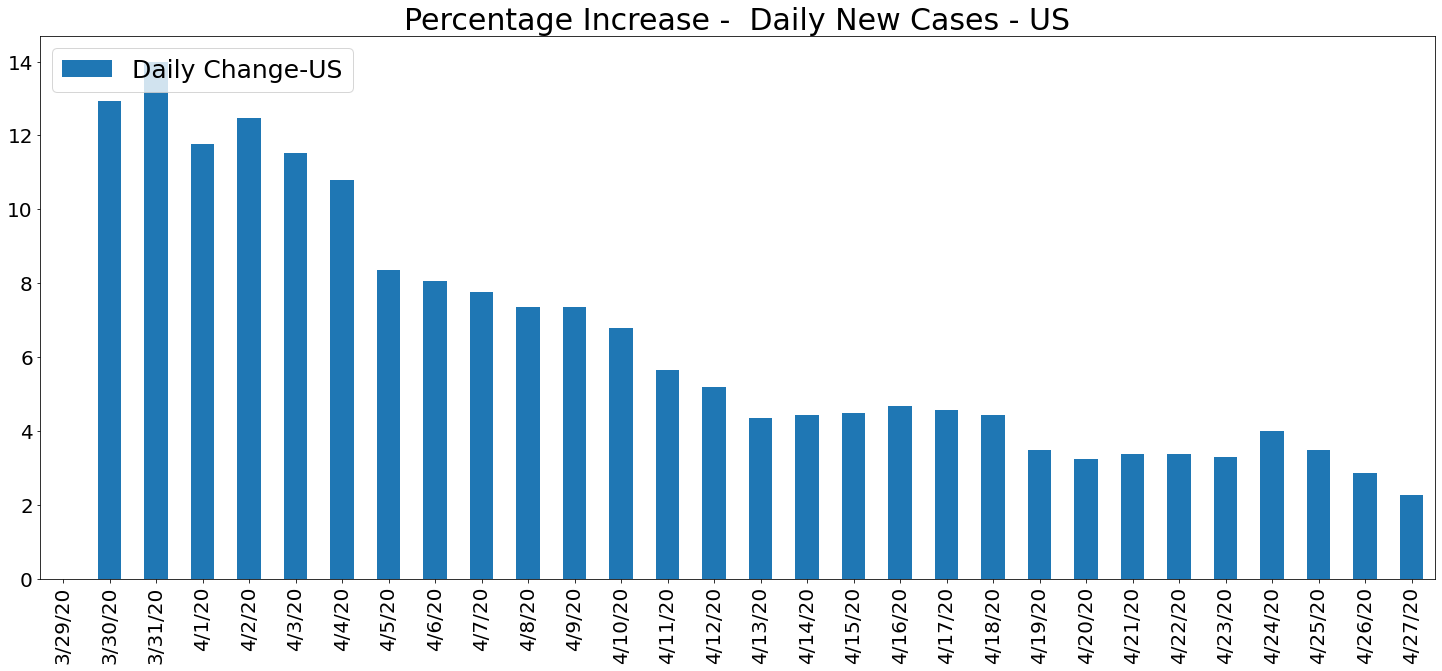

In [146]:
drawDeltaChartForVirus(["US"],True )

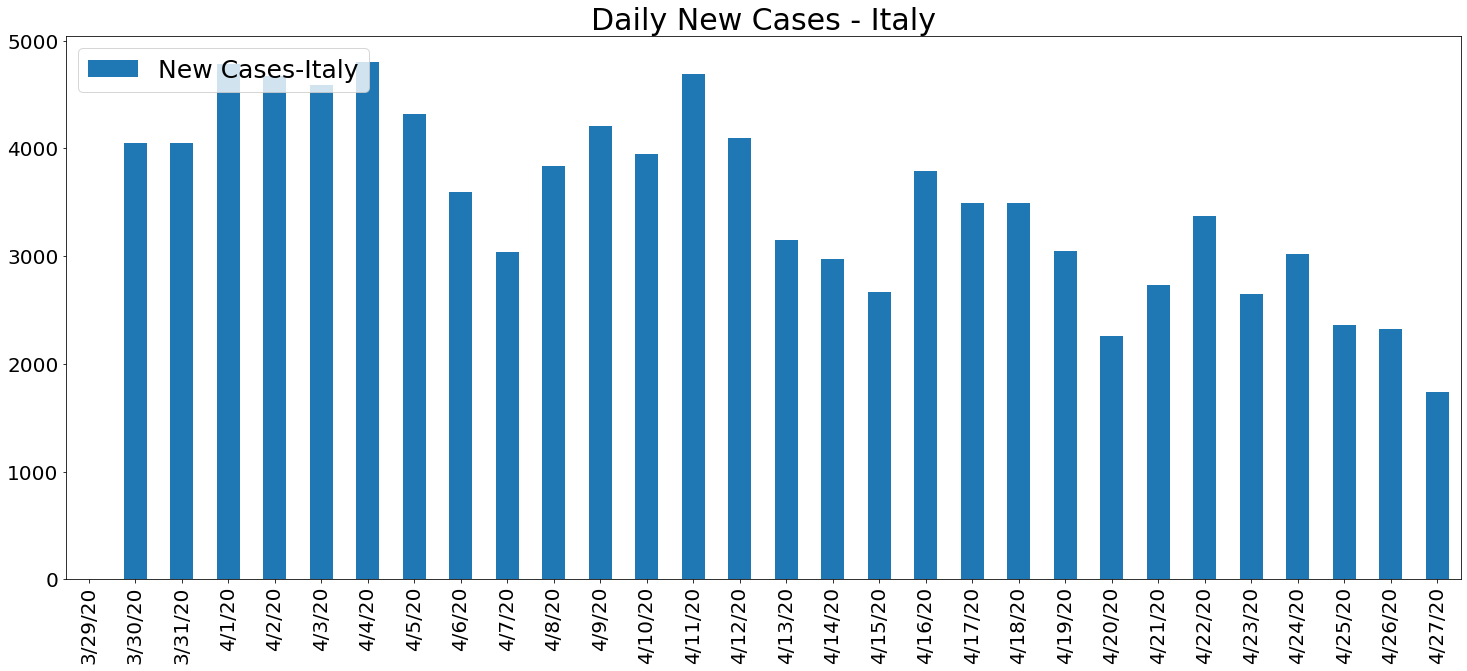

In [147]:
drawDeltaChartForVirus(["Italy"],False )

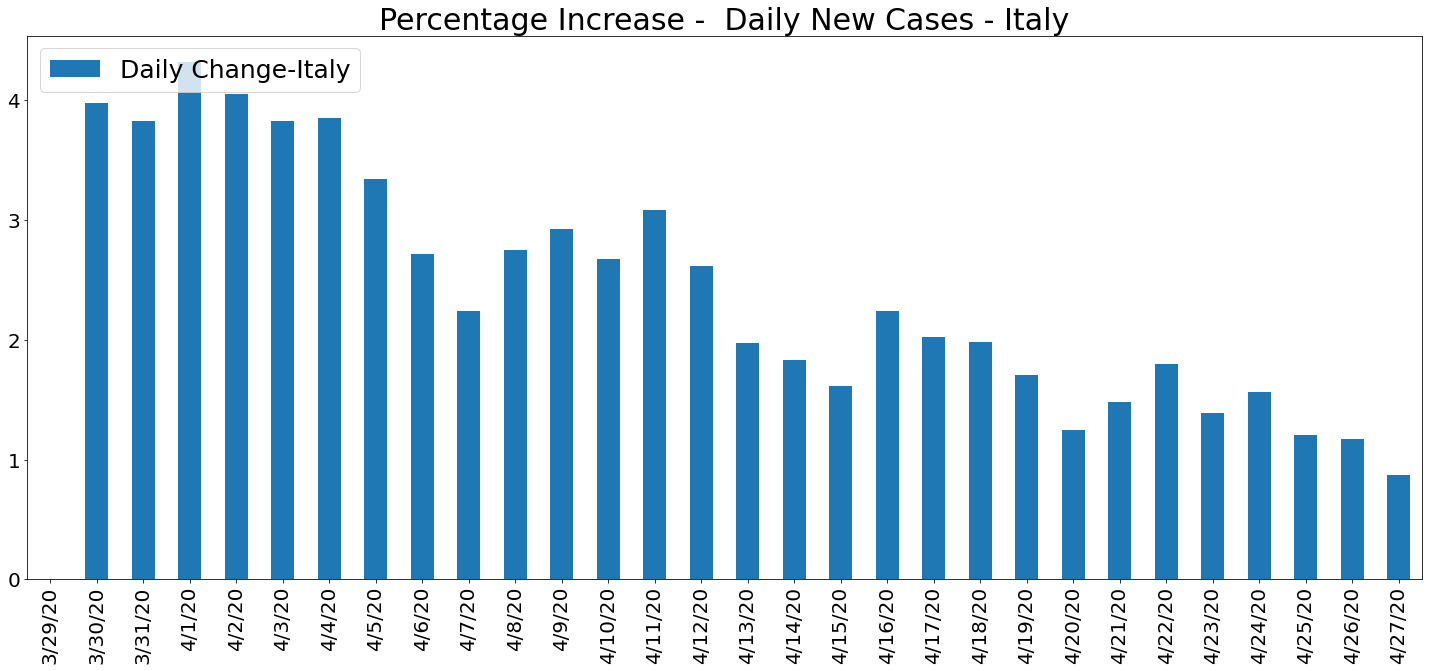

In [148]:
drawDeltaChartForVirus(["Italy"],True )